# Classification


# Make some data
We're going to first fake some data.  We'll come up with a category for N subjects (true_cat) as being 0/1.  We'll then create some random, normal vectors that will form our predictors -- the things we'll actually observe in our experiment. These will have some fraction of the truth included with their noise.  For one of these, we'll call it a latent variable. We won't actually observe it, but we'll observe two other variables derived from this.

In [72]:
import numpy as np
import pandas as pd

N=500
SNR=5  # Adjust this to make the groups more or less distinct

# Setup our true category membership
rng = np.random.default_rng()
true_cat=rng.choice([0,1],N,p=[0.5, 0.5])

noise=rng.normal(size=(N,4))  # 4 columns of nice Gaussian noise
data=np.zeros_like(noise)
data[:,0]= 0.2 * true_cat * SNR + noise[:,0]  # 1st data column has 0.2 worth of signal
data[:,1]= -0.3 * true_cat  * SNR + noise[:,1]  # 2nd data column has 0.3 worth of signal but is inversely correlated

latent=0.5 * true_cat  * SNR + rng.normal(size=N)  # This is pretty predictive, but we won't observe it directly
data[:,2] = 0.4 * latent + noise[:,2] # Here are the 2 we observe. Each gets its own independent noise atop the latent
data[:,3] = 0.5 * latent + noise[:,3]

df=pd.DataFrame(np.c_[data,true_cat],columns=('A','B','C','D','truth'))


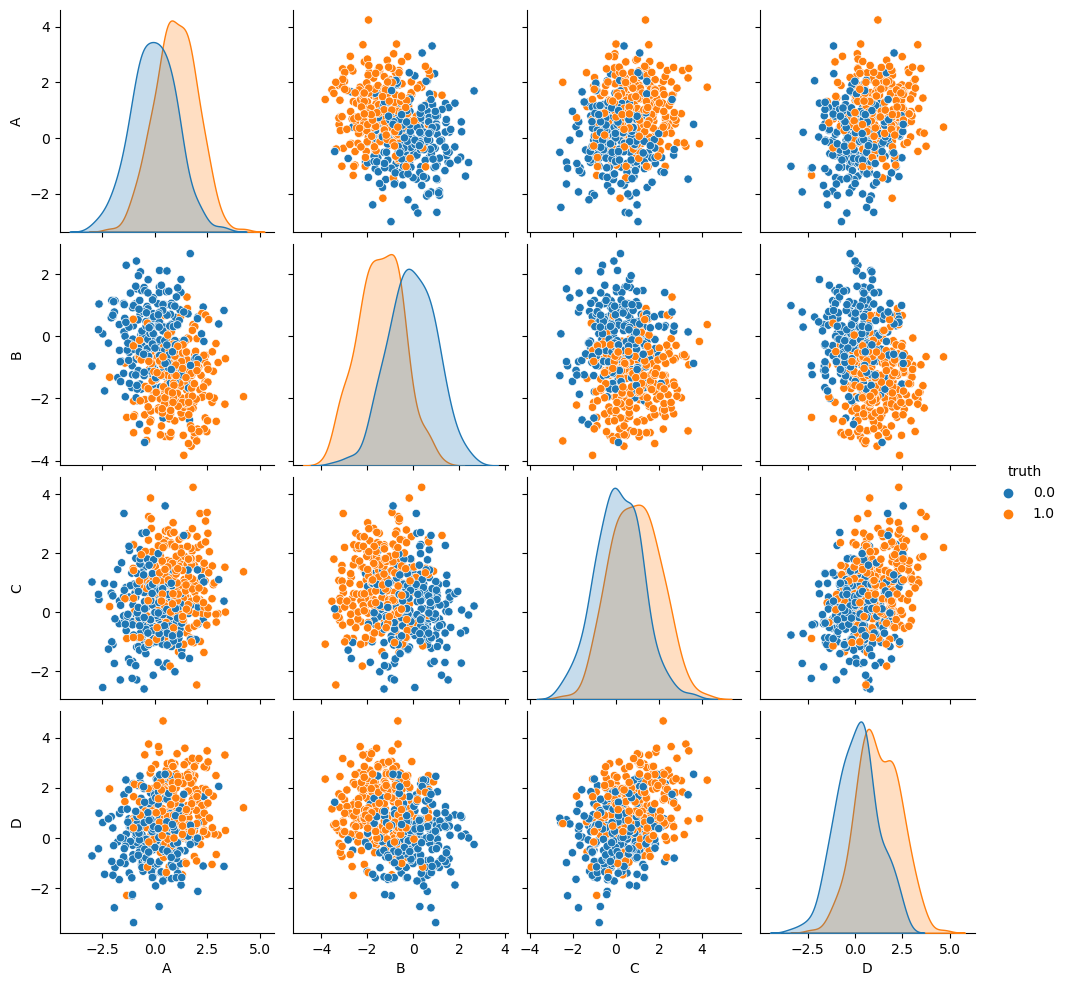

In [73]:
import seaborn as sns

sns.pairplot(df,hue='truth',aspect=1)


In [74]:
foo=df.loc[:,'A':'D']

# Standard regression
First, let's use statsmodels to do a logistic regression on this

In [75]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant

print('Individual variables as separate logistic regressions')
for i in range(4):
    predictors=add_constant(data[:,i])
    modelfit=sm.Logit(true_cat,predictors).fit(disp=False)
    print(f'Predictor {i}: coef = {modelfit.params[0]:.2f}  p={modelfit.pvalues[0]:.2f}  overall r^2 = {modelfit.prsquared:.2f}  ')


print('\n\nMultiple logistic regression')
# Can use the numpy array version like the above
predictors=add_constant(data) # Give us a constant / offset term
predictors=data
modelfit=sm.Logit(true_cat,predictors).fit(disp=False)
print(modelfit.summary())
print('Confusion matrix')
print(modelfit.pred_table())

# Or can use the Pandas version, here just gabbing 2 variables but also using the R-style 
# way of defining the formula.  Note using "smf" to do this rather than "sm".  By default
# this adds an intercept / constant term
print('\n\nMultiple logistic regression using just A and B, Pandas, and R-style equation')
modelfit=smf.logit(formula = 'truth ~ A * B',data=df).fit(disp=False)
print(modelfit.summary())
print('Confusion matrix')
print(modelfit.pred_table())





Individual variables as separate logistic regressions
Predictor 0: coef = -0.41  p=0.00  overall r^2 = 0.16  
Predictor 1: coef = -0.94  p=0.00  overall r^2 = 0.27  
Predictor 2: coef = -0.27  p=0.01  overall r^2 = 0.08  
Predictor 3: coef = -0.53  p=0.00  overall r^2 = 0.16  


Multiple logistic regression
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  500
Model:                          Logit   Df Residuals:                      496
Method:                           MLE   Df Model:                            3
Date:                Thu, 01 Jun 2023   Pseudo R-squ.:                  0.2773
Time:                        10:28:52   Log-Likelihood:                -250.37
converged:                       True   LL-Null:                       -346.43
Covariance Type:            nonrobust   LLR p-value:                 2.132e-41
                 coef    std err          z      P>|z|     

explained variance ratio (first two components): [0.42397209 0.23411953]


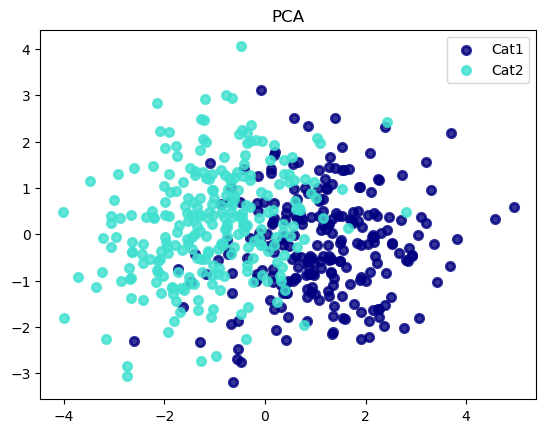

In [76]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


X = data
y = true_cat
target_names = ('Cat1','Cat2')

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# lda = LinearDiscriminantAnalysis(n_components=2)
# X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

plt.figure()
colors = ["navy", "turquoise"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA")

# plt.figure()
# for color, i, target_name in zip(colors, [0, 1], target_names):
#     plt.scatter(
#         X_r2[y == i, 0], X_r2[y == i, 1], alpha=0.8, color=color, label=target_name
#     )
# plt.legend(loc="best", shadow=False, scatterpoints=1)
# plt.title("LDA")

plt.show()

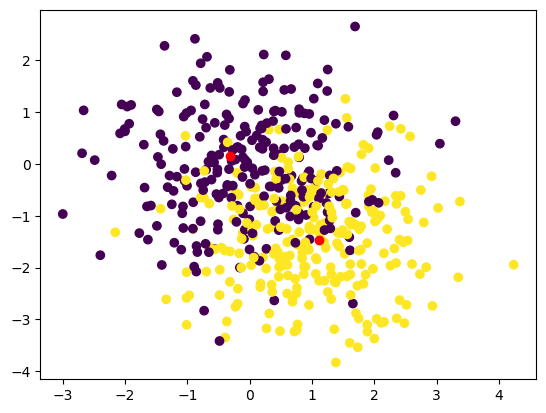

In [77]:
# Using Scipy.stat's kmeans
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html#scipy.cluster.vq.kmeans

from scipy.cluster.vq import vq, kmeans

# Find 2 clusters in the data, right now just using A and B (1st 2 columns)
codebook, distortion = kmeans(data[:,0:2], 2)

plt.scatter(data[:, 0], data[:, 1],c=true_cat)
plt.scatter(codebook[:, 0], codebook[:, 1], c='r')
plt.show()


# Using an SVM and scikit-learn
A Support Vector Machine (SVM) tries to come up with a line, plane, or hyperplane (depending on your number of dimensions) that will maximally split your data into groups. We're going to do this two ways. First, we'll just take 2 of our dimensions and run the SVM on all of the data, basing this on a simple example from the `scikit` docs.  Next, we'll do this more closely to what you'd actually do. We have 4 predictor variables (and so might as well use them all) and, since this is `scikit` and we're being modern in our approach, we'll run things as separate train / test sets.

In truth, you'd likely take it a step further and do something like a k-fold validation. Why just have one set of say 20% held out? What's so special about that split?  You'd likely run your train/test splits multiple times and all, but this at least shows the idea.


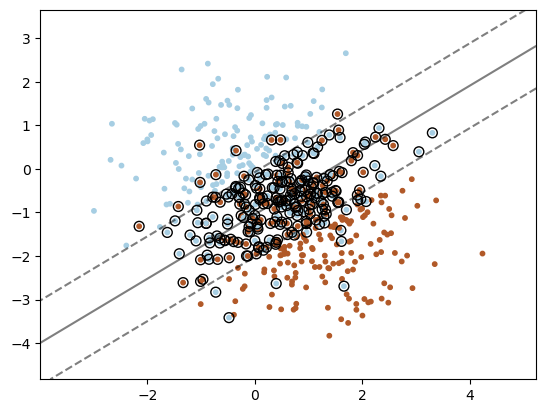

In [80]:
# Using scikit-learn's SVM, a simple 2-axis version
# https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-py
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay

# Find a boundary in the data, right now just using A and B (1st 2 columns) that splits our category labels best
X=data[:,0:2]
y=true_cat
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(X, y)


plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=50,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()



There are 400 samples for training and 100 samples for testing.
Training set data analysis - this is kinda cheating
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       198
           1       0.82      0.83      0.83       202

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400

Testing set data analysis
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        46
           1       0.87      0.83      0.85        54

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



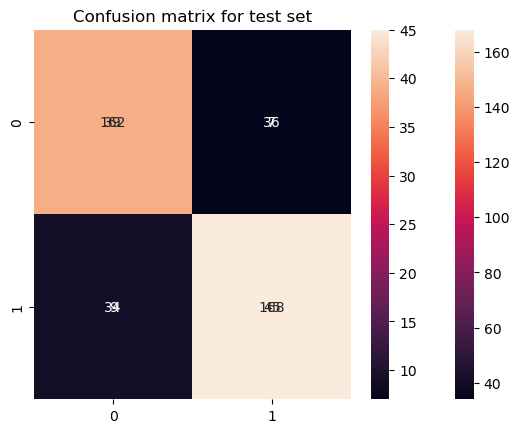

In [85]:
# A more realistic example
# https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Setup our data
X=data
y=true_cat

# Split this into separate training and testing sets
seed=1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = seed)
print(f'There are {X_train.shape[0]} samples for training and {X_test.shape[0]} samples for testing.')

# Run our SVM
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)

# Test it on our training set
y_pred_train = svc.predict(X_train)
cm = confusion_matrix(y_train,y_pred_train)
print('Training set data analysis - this is kinda cheating but the comparison helps detect overfitting')
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix for training set') # fmt='d' formats the numbers as digits, which means integers
print(classification_report(y_train,y_pred_train))

# Test it on our left-out testing set
y_pred = svc.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print('Testing set data analysis')
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix for test set') # fmt='d' formats the numbers as digits, which means integers
print(classification_report(y_test,y_pred))

